## Preliminaries

In [1]:
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec

import gurobipy as gp
from gurobipy import GRB

In [2]:
'''Return Euclidean distance from a to b'''
def dist(a, b):
    return math.sqrt(sum([(i-j)**2 for i,j in zip(a,b)]))

'''Return closest facility to p from set opens.
   return -1 if opens is empty
'''
def find_closest_f(opens, p):
    if not opens: # No facility has opened yet
        return (-1,0)
    dists = list(map(lambda x: dist(x,p), opens))
    idx = np.argmin(dists)
    return (idx, dists[idx])

In [3]:
'''
Generates uniform random points on the grid
'''
def uniform_random_points(n, MIN=1, MAX=20):
    points = []
    for _ in range(n):
        x, y = np.random.randint(MIN, MAX), np.random.randint(MIN, MAX)
        points.append((x,y))
    return points

## Solvers (Optimal, Meyerson, PredFL)

### Optimal

In [4]:
from itertools import product

def LPG(customers, facilities, f, savefile=None):
    num_customers = len(customers)
    num_facilities = len(facilities)
    cartesian_prod = list(product(range(num_customers), range(num_facilities)))

    # Compute cost
    setup_cost = [f] * num_facilities
    shipping_cost = {(c,f): dist(customers[c], facilities[f]) for c, f in cartesian_prod}
    
#     print("Initialize Model")
    
    m = gp.Model('facility_location')
    m.Params.LogToConsole = 0
    m.Params.Method = 1

    select = m.addVars(num_facilities, lb=0, vtype=GRB.CONTINUOUS, name='Select')
    assign = m.addVars(cartesian_prod, lb=0, vtype=GRB.CONTINUOUS, name='Assign')

    m.addConstrs((assign[(c,f)] <= select[f] for c,f in cartesian_prod), name='Setup2ship')
    m.addConstrs((gp.quicksum(assign[(c,f)] for f in range(num_facilities)) == 1 for c in range(num_customers)), name='Demand')

    m.setObjective(select.prod(setup_cost)+assign.prod(shipping_cost), GRB.MINIMIZE)
    
#     print("Optimize Model")

    m.optimize()
    
    if savefile:
        m.write("{0}.sol".format(savefile))
    
    # Retrieve Solution 
    
    n = num_customers
    M = num_facilities
    
    c = np.array(
        [
            [dist(facilities[i], customers[j]) for j in range(n)]
            for i in range(M)
        ]
    )
    
    ret_x = np.array([ select[i].x for i in range(M)])
    # y[i,j] facility i connects with demand j
    ret_y = np.array(
        [
            [assign[(j,i)].x for j in range(n)]
            for i in range(M)
        ]
    )

    return ret_x, ret_y, c

#### Rounding

In [5]:
def primal_rounding(x, y, c):
    # x: 1*n, y: n*n
    n = x.size
    #### ----- filtering ------- ######
    c_bar = np.array([ c[:,j] @ y[:,j] for j in range(n)])
    
    # S_j sets
    S = []
    S_l = []
    # for each demand j: Sj = facilities where c[i,j] < 2c_bar[j]
    for j in range(n):
        cand = []
        for i in range(n):
            if c[i,j] <= c_bar[j]: cand.append(i)
        S.append(set(cand))
        S_l.append(cand)
    
    y_bar = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i in S[j]:
                # maybe change that later
                y_bar[i,j] = y[i,j] / np.sum([y[i,j] for i in S_l[j]])
                
    x_bar = np.minimum(2 * x, 1)
            
    #### ----- rounding ------- ######
    xx = np.zeros(n)
    yy = np.zeros((n,n))
    
    unassigned = np.array([True] * n)
    cnt = 0
    while(cnt < n):
        # find min unassigned
        c_min = np.inf
        c_idx = 0
        for j in range(n):
            if unassigned[j] and (c_bar[j] < c_min):
                c_min = c_bar[j]
                c_idx = j
        
        unassigned[c_idx] = False
        f_idx = S_l[c_idx][0]
        
        # open facility
        xx[f_idx] = 1
        
        # assign demand to facility
        yy[f_idx, c_idx] = 1
        cnt += 1
        
        for j in range(n):
            if (j != c_idx) and (unassigned[j]):
                if (S[c_idx].intersection(S[j])):
                    unassigned[j] = False
                    
                    yy[f_idx, j] = 1
                    cnt += 1
    return xx,yy

In [6]:
# use lpg2 for now

def Optimal(demands, facilities, f, savefile=None):
    n = len(demands)
    M = len(facilities)
    
    lx, ly, c = LPG(demands, facilities, f, savefile)
    x, y = primal_rounding(lx, ly, c)
    
    cost = 0
    ret_facilities = []
    for i in range(n):
        if x[i]:
            ret_facilities.append(demands[i])
    cost += f * len(ret_facilities)
    
    assignments = []
    for j in range(n):
        for i in range(M):
            if y[i,j]:
                assignments.append((demands[j], facilities[i]))
                cost += c[i,j]
                
                break
    return cost, facilities, assignments

### Meyerson @ PredFl

In [7]:
'''
Run Meyerson's randomized algorithm on data, with facility cost f
return: (set of open facilities, pairs of (facilities,points assigned to facs) and total cost of solution
'''
from collections import defaultdict
debug = False

def Meyerson(points, f):
    global debug
    open_facs = []
    cost = 0
    
#     assg = defaultdict(list) # Contains tuples of the form (open fac, point connected to fac)
    assg = [] # Contains tuples of the form (open fac, point connected to fac)
    
    if(debug): print(points)
    
    for p in points:
        if(debug): print("Point : ", p)
        fopen, delta = find_closest_f(open_facs, p)
        if(debug): print("Closest facility :", fopen)
        if(fopen == -1):
            delta = f
        else:
            delta = min(f, delta)
            
        if(np.random.binomial(1, delta/f) == 1):# coin toss succeeds
            open_facs.append(p)
            cost += f
            assg.append((p, p))
        else: # Facility did not open, connect instead
            cost += delta
            assg.append((p, open_facs[fopen]))
            
    return (cost, open_facs, assg)

In [8]:
'''
Learning Augmented Meyerson
data: list(point, prediction)
'''

def PredFL(points, preds, f):
    open_facs = []
    cost = 0
#     assg = defaultdict(list) # Contains tuples of the form (open fac, point connected to fac)
    assg = []
    
    for p, pred in zip(points,preds):
        fopen, _ = find_closest_f(open_facs, p)
        if(fopen == -1):
            delta = f
        else:
            delta = min(f, dist(pred, open_facs[fopen]))
        
        if(np.random.binomial(1, delta/f) == 1):# coin toss succeeds
            open_facs.append(pred)
            cost += f + dist(p, pred)
            assg.append((p, pred))
        else: # Facility did not open, connect instead
            opfac = open_facs[fopen]
            cost += dist(p, opfac)
            assg.append((p, opfac))
            
    return (cost, open_facs, assg)

## Utilities

### Predictions

In [227]:
'''
Perturb generator
'''
def gaussian_perturb_generator(assignments, percentage, std):
    preds = []
    for p, c in assignments:
        np_p = np.asarray(p)
        np_c = np.asarray(c)
        
        if (np.array_equal(np_c, np_p)) or (percentage == 0):
            preds.append(np_c)
            continue
        
        gaussian_perc = np.random.normal(percentage, std)
        
        gaussian_perc = max(0, gaussian_perc)
        gaussian_perc = min(1, gaussian_perc)
        
        pred = np_c + gaussian_perc * (np_p - np_c)
        
        preds.append(pred)
    return preds

In [274]:
def random_perturb_generator(assignments, percentage, std=0):
    preds = []
    for p, c in assignments:
        np_p = np.asarray(p)
        np_c = np.asarray(c)
        
        if (np.array_equal(np_c, np_p)) or (percentage == 0):
            preds.append(np_c)
            continue
        
        random_vec = np.random.choice([-1,1], (10,))
        
        pred = np_c + percentage * (np_p - np_c) * random_vec
        
        preds.append(pred)
    return preds

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


## CovType Data (https://archive.ics.uci.edu/ml/datasets/covertype) [NeurIPS]

In [10]:
import pandas as pd

In [11]:
def ct_split_batches(filename, batch_size, header=None):
    df = pd.read_csv(filename, nrows=2e6, usecols=list(range(10)), header=header)
    np_df = df.to_numpy()

    return np.array_split(np_df, np_df.shape[0] // batch_size)
#     return np_df

### [1] Initialization

In [12]:
def run_experiments(points, f, optimal_solution, predictor, predictor_params, std, avg_iterations=1):
    opt_cost, opt_facs, opt_assgn = optimal_solution

    pred_costs = []
    
    for param in predictor_params:
        preds = predictor(opt_assgn, param, std)

        avg_pred = 0
        for _ in range(avg_iterations):
            pred_cost, _, _ = PredFL(points, preds, f)
            avg_pred += pred_cost

            
        avg_pred /= avg_iterations
        pred_costs.append(avg_pred)
    
    return pred_costs

In [13]:
def batches_experiments(batches, batches_number, f, generator, percentages, std, avg_iterations, optimal_solutions=None):
    pred_costs = []

    total_batches = len(batches)
    batches_number = min(batches_number, total_batches)
    
    cnt = 1
    for batch_id in range(batches_number):
        print('[{0}]'.format(batch_id) , end=' ')
        cnt += 1
        
        batch = batches[batch_id]
        optimal_solution = optimal_solutions[batch_id]
        
        params = {
            'points' : batch,
            'f' : f,
            'optimal_solution' : optimal_solution,
            'predictor' : generator,
            'predictor_params' : percentages,
            'std' : std,
            'avg_iterations' : avg_iterations,
        }

        print("RUN", end=' ')
        pred_cost = run_experiments(**params)
        print("STOP")

        pred_costs.append(pred_cost)
        
    return pred_costs

In [14]:
def calculate_cp(optimal_cost, costs):
    return (np.asarray(costs) / optimal_cost)

In [15]:
def simulated_costs(meyerson_cost, costs):
    return np.minimum(costs, meyerson_cost)

### [1.2] Split Dataset

In [16]:
ct_batch_size = 1000

ct_batches = ct_split_batches("covtype.data", ct_batch_size)

In [17]:
print("# covertype batches", len(ct_batches))

# covertype batches 581


### [2] Calculate Optimal Solutions

In [171]:
ct_batches_number = 5

ct_f = 1000

In [154]:
def get_n_solutions(batches, f, n):
    optimal_solutions = []
    for i in range(n):
        print(i, end=' ')
        optimal_solutions.append(Optimal(batches[i], batches[i], f))
    return optimal_solutions
        

In [ ]:
ct_optimal_solutions = get_n_solutions(ct_batches, ct_f, 20)

### [2.1] Save/Retrieve Optimal Solutions

In [156]:
import pickle

In [157]:
def save_solutions(optimal_solutions, name):
     with open(name + '.pkl', 'wb') as f:
            pickle.dump(optimal_solutions, f)

def retrieve_solutions(name):
    with open(name + '.pkl', 'rb') as f:
        optimal_solutions = pickle.load(f)
    return optimal_solutions

In [173]:
# save_solutions(ct_optimal_solutions, 'ct_optimal_solutions_10_1000')

In [286]:
ct_optimal_solutions = retrieve_solutions('ct_optimal_solutions_10_1000')

### [2.2] Get wcs batches

In [288]:
def get_wcs(optimal_solution):
    _, _, opt_assgn = optimal_solution
    opt_assgn.sort(key=lambda x:dist(x[0],x[1]), reverse=True)
    wcs_batch = [d[0] for d in opt_assgn]
    
    return np.asarray(wcs_batch)

In [289]:
ct_batches_wcs = []

for optimal_solution in ct_optimal_solutions:
    ct_batches_wcs.append(get_wcs(optimal_solution))

### [3] Experiments

In [301]:
msrm_num = 20

In [302]:
ct_batches_number = 5

ct_avg_iterations = 20

ct_avg_percentage_iters = np.linspace(0,1.2,msrm_num)

x_percentages = ct_avg_percentage_iters
x_batches = np.arange(0,ct_batches_number,1)

#### [3.1] Optimal Costs

In [293]:
ct_optimal_costs = [ct_optimal_solutions[i][0] for i in range(ct_batches_number)]
ct_avg_optimal = np.mean(ct_optimal_costs)

In [294]:
ct_avg_optimal

248121.44814186107

#### [3.2] Meyerson Costs

In [164]:
ct_meyerson_costs = []

for i in range(ct_batches_number):
    print(i, end=' ')
    ct_batch_wcs = ct_batches_wcs[i]
    
    avg_mey = 0
    for j in range(ct_avg_iterations):
        mey, _, _ = Meyerson(ct_batch_wcs, ct_f)
        avg_mey += mey
    
    ct_meyerson_costs.append(avg_mey/ct_avg_iterations)
    

0 1 2 3 4 

In [165]:
ct_avg_meyerson = np.mean(ct_meyerson_costs)

#### [3.3] Percentage (std=0)

In [ ]:
%%time
ct_batches_avg_costs = batches_experiments(
    ct_batches_wcs, 
    ct_batches_number, 
    ct_f, 
    gaussian_perturb_generator,
    ct_avg_percentage_iters,
    0,
    ct_avg_iterations,
    ct_optimal_solutions
)

[0] RUN 

In [207]:
# save_solutions(ct_batches_avg_costs, 'ct_batches_avg_costs')

In [111]:
# ct_batches_avg_costs = retrieve_solutions('ct_batches_avg_costs')

In [222]:
ct_batches_mean_costs_r = np.mean(ct_batches_avg_costs, 0)

In [223]:
ct_batches_mean_costs = simulated_costs(ct_avg_meyerson, ct_batches_mean_costs_r)

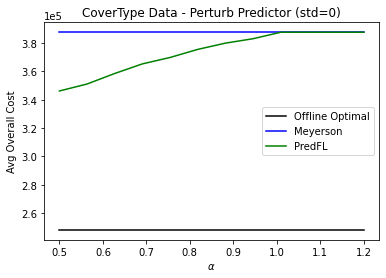

In [224]:
plt.plot(x_percentages, [ct_avg_optimal] * msrm_num, 'k', label='Offline Optimal')
plt.plot(x_percentages, [ct_avg_meyerson] * msrm_num, 'b', label='Meyerson')
plt.plot(x_percentages, ct_batches_mean_costs, 'g', label='PredFL')

plt.xlabel(r'$\alpha$')
plt.ylabel('Avg Overall Cost')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.legend()
plt.title("CoverType Data - Perturb Predictor (std=0)")

plt.savefig("covertype_avg_cost")

In [225]:
ct_batches_mean_cp = calculate_cp(ct_avg_optimal, ct_batches_mean_costs)

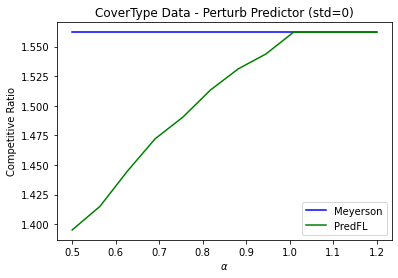

In [226]:
plt.plot(x_percentages, [ct_avg_meyerson/ct_avg_optimal] * msrm_num, 'b', label='Meyerson')
plt.plot(x_percentages, ct_batches_mean_cp, 'g', label='PredFL')

plt.xlabel(r'$\alpha$')
plt.ylabel('Competitive Ratio')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.legend()
plt.title("CoverType Data - Perturb Predictor (std=0)")

plt.savefig("covertype_avg_cp")

#### [3.3] Percentage (std=0.2)

In [229]:
%%time
ct_batches_avg_costs_02 = batches_experiments(
    ct_batches_wcs, 
    ct_batches_number, 
    ct_f, 
    gaussian_perturb_generator,
    ct_avg_percentage_iters,
    0.2,
    ct_avg_iterations,
    ct_optimal_solutions
)

[0] RUN STOP
[1] RUN STOP
[2] RUN STOP
CPU times: user 27min 23s, sys: 11.7 s, total: 27min 34s
Wall time: 27min 10s


In [205]:
# save_solutions(ct_batches_avg_costs_02, 'ct_batches_avg_costs_02')

In [121]:
# ct_batches_avg_costs = retrieve_solutions('ct_batches_avg_costs_02')

In [230]:
ct_batches_mean_costs_02_r = np.mean(ct_batches_avg_costs_02, 0)

In [231]:
ct_batches_mean_costs_02 = simulated_costs(ct_avg_meyerson, ct_batches_mean_costs_02_r)

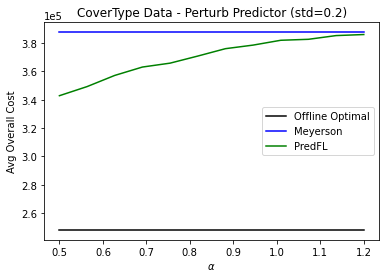

In [232]:
plt.plot(x_percentages, [ct_avg_optimal] * msrm_num, 'k', label='Offline Optimal')
plt.plot(x_percentages, [ct_avg_meyerson] * msrm_num, 'b', label='Meyerson')
plt.plot(x_percentages, ct_batches_mean_costs_02, 'g', label='PredFL')

plt.xlabel(r'$\alpha$')
plt.ylabel('Avg Overall Cost')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.legend()
plt.title("CoverType Data - Perturb Predictor (std=0.2)")

plt.savefig("covertype_avg_cost_02")

In [233]:
ct_batches_mean_cp_02 = calculate_cp(ct_avg_optimal, ct_batches_mean_costs_02)

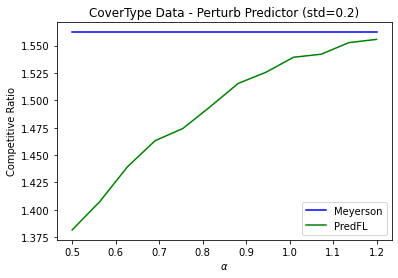

In [234]:
plt.plot(x_percentages, [ct_avg_meyerson/ct_avg_optimal] * msrm_num, 'b', label='Meyerson')
plt.plot(x_percentages, ct_batches_mean_cp_02, 'g', label='PredFL')

plt.xlabel(r'$\alpha$')
plt.ylabel('Competitive Ratio')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.legend()
plt.title("CoverType Data - Perturb Predictor (std=0.2)")

plt.savefig("covertype_avg_cp_02")

#### [3.3] Percentage (std=0.4)

In [235]:
%%time
ct_batches_avg_costs_04 = batches_experiments(
    ct_batches_wcs, 
    ct_batches_number, 
    ct_f, 
    gaussian_perturb_generator,
    ct_avg_percentage_iters,
    0.4,
    ct_avg_iterations,
    ct_optimal_solutions
)

[0] RUN STOP
[1] RUN STOP
[2] RUN STOP
[3] RUN STOP
[4] RUN STOP
CPU times: user 29min 27s, sys: 14.2 s, total: 29min 41s
Wall time: 29min 22s


In [203]:
# save_solutions(ct_batches_avg_costs_04, 'ct_batches_avg_costs_04')

In [ ]:
# ct_batches_avg_costs_04 = retrieve_solutions('ct_batches_avg_costs_04')

In [236]:
ct_batches_mean_costs_04_r = np.mean(ct_batches_avg_costs_04, 0)

In [237]:
ct_batches_mean_costs_04 = simulated_costs(ct_avg_meyerson, ct_batches_mean_costs_04_r)

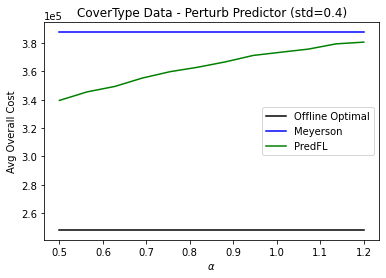

In [238]:
plt.plot(x_percentages, [ct_avg_optimal] * msrm_num, 'k', label='Offline Optimal')
plt.plot(x_percentages, [ct_avg_meyerson] * msrm_num, 'b', label='Meyerson')
plt.plot(x_percentages, ct_batches_mean_costs_04, 'g', label='PredFL')

plt.xlabel(r'$\alpha$')
plt.ylabel('Avg Overall Cost')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.legend()
plt.title("CoverType Data - Perturb Predictor (std=0.4)")

plt.savefig("covertype_avg_cost_04")

In [241]:
ct_batches_mean_cp_04 = calculate_cp(ct_avg_optimal, ct_batches_mean_costs_04)

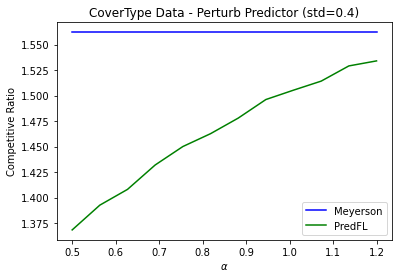

In [242]:
plt.plot(x_percentages, [ct_avg_meyerson/ct_avg_optimal] * msrm_num, 'b', label='Meyerson')
plt.plot(x_percentages, ct_batches_mean_cp_04, 'g', label='PredFL')

plt.xlabel(r'$\alpha$')
plt.ylabel('Competitive Ratio')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.legend()
plt.title("CoverType Data - Perturb Predictor (std=0.4)")

plt.savefig("covertype_avg_cp_04")

#### Performance over std

In [243]:
std_number = 3
std_iters = [0, 0.2, 0.4]

std_cp = [ct_batches_mean_cp,
         ct_batches_mean_cp_02,
         ct_batches_mean_cp_04]

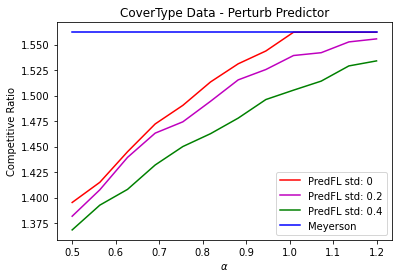

In [244]:
# colors = ['r', 'y', 'c', 'm', 'green']
colors = ['r', 'm', 'green']

for i in range(std_number):
    plt.plot(x_percentages, std_cp[i], colors[i], label='PredFL std: {0}'.format(round(std_iters[i],2)))

plt.plot(x_percentages, [ct_avg_meyerson/ct_avg_optimal] * msrm_num, 'b', label='Meyerson')

plt.xlabel(r'$\alpha$')
plt.ylabel('Competitive Ratio')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.legend()
plt.title("CoverType Data - Perturb Predictor")

plt.savefig("covertype_cp_std")

#### [3.6] Percentage over alpha (random perturb generator)

In [ ]:
msrm_num = 12

In [ ]:
ct_batches_number = 5

ct_avg_iterations = 20

ct_avg_percentage_iters = np.linspace(0,1.2,msrm_num)

x_percentages = ct_avg_percentage_iters
x_batches = np.arange(0,ct_batches_number,1)

In [ ]:
%%time
ct_batches_random_avg_costs = batches_experiments(
    ct_batches_wcs, 
    ct_batches_number, 
    ct_f, 
    random_perturb_generator,
    ct_avg_percentage_iters,
    0,
    ct_avg_iterations,
    ct_optimal_solutions
)

In [207]:
# save_solutions(ct_batches_random_avg_costs, 'ct_batches_random_avg_costs')

In [111]:
# ct_batches_random_avg_costs = retrieve_solutions('ct_batches_random_avg_costs')

In [279]:
ct_batches_random_mean_costs_r = np.mean(ct_batches_random_avg_costs, 0)

In [280]:
ct_batches_random_mean_costs = simulated_costs(ct_avg_meyerson, ct_batches_random_mean_costs_r)

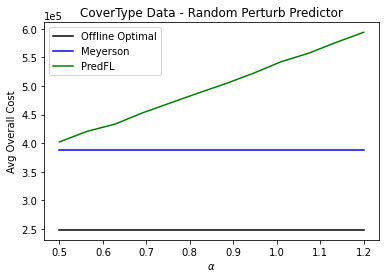

In [282]:
plt.plot(x_percentages, [ct_avg_optimal] * msrm_num, 'k', label='Offline Optimal')
plt.plot(x_percentages, [ct_avg_meyerson] * msrm_num, 'b', label='Meyerson')
plt.plot(x_percentages, ct_batches_random_mean_costs_r, 'g', label='PredFL')

plt.xlabel(r'$\alpha$')
plt.ylabel('Avg Overall Cost')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.legend()
plt.title("CoverType Data - Random Perturb Predictor")

plt.savefig("covertype_random_avg_cost")

In [261]:
ct_batches_random_mean_cp = calculate_cp(ct_avg_optimal, ct_batches_random_mean_costs)

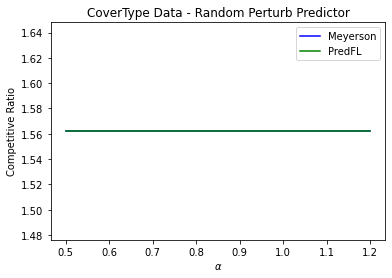

In [262]:
plt.plot(x_percentages, [ct_avg_meyerson/ct_avg_optimal] * msrm_num, 'b', label='Meyerson')
plt.plot(x_percentages, ct_batches_random_mean_cp, 'g', label='PredFL')

plt.xlabel(r'$\alpha$')
plt.ylabel('Competitive Ratio')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.legend()
plt.title("CoverType Data - Random Perturb Predictor")

plt.savefig("covertype_random_avg_cp")